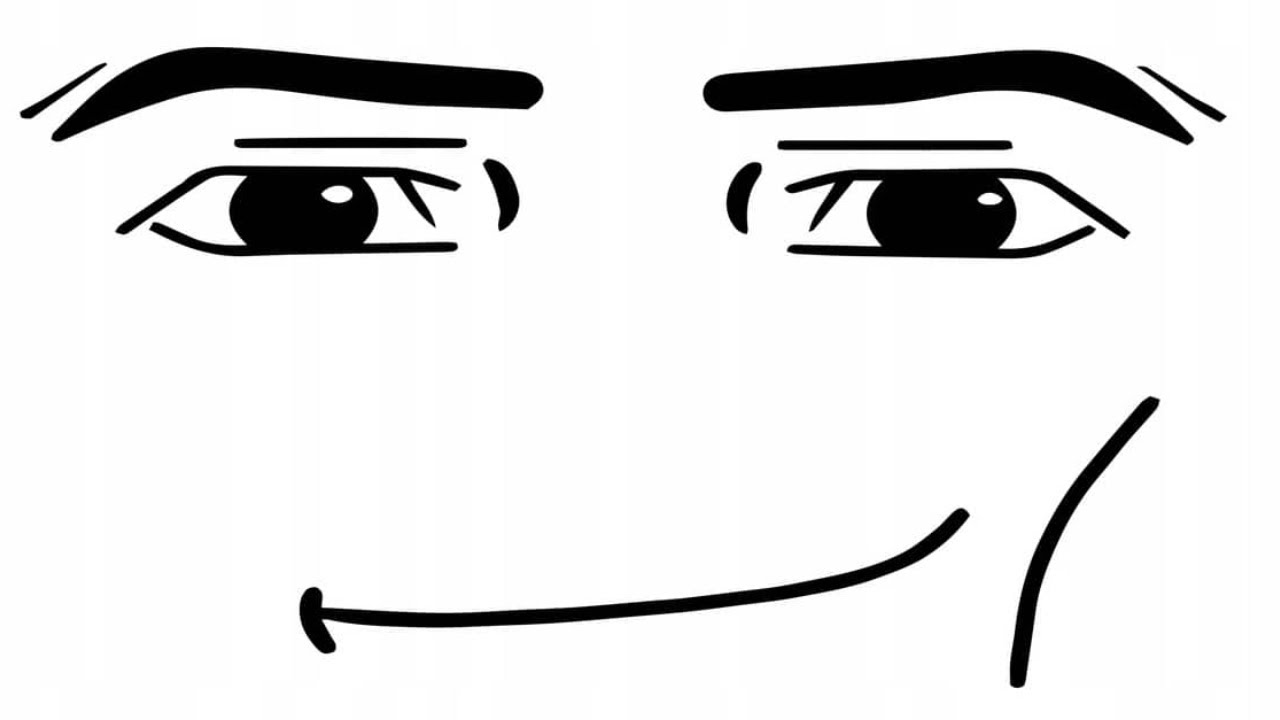

In [1]:
import pandas as pd
import numpy as np
import geopy
import random

In [2]:
airport = pd.read_csv("airport.csv")
airstrip = pd.read_csv("airstrip.csv")
employee = pd.read_csv("employee.csv")
airliner = pd.read_csv("airliner.csv")

airliner = airliner.loc[:, ['airport_id', 'airliner_id']]
airstrip = airstrip.loc[:, ['airport_id', 'airstrip_id']]

---

#### Цель

Сгенерировать данные о полётах за месяц: 

- Сами карточки полётов
- Назначенные полосы и самолёты
- История статусов самолёта для каждого полёта
- Билеты на каждый полёт
- Привязанные к билетам пассажиры
- Назначенные на каждый полёт диспетчеры и пилоты

---

#### Алгоритм

1. Выбираем диапазон дат для генерации данных. Дальнейшие действия повторяются в рамках каждой даты
2. Внутри даты выбираем интервал для генерации времени вылета. Для простоты можно снять несколько часов сверху, чтобы полёт приходился только на одни сутки
3. Генерируем запланированное время вылета, в зависимости от него запланированное время прибытия
4. Генерируем фактические времена вылета и прибытия: для первого - как запланированное + 0-30 минут, для второго - запланированное + опоздание вылета + 0-30 минут
5. Случайно выбираем полосы вылета и посадки из соответствуюих аэропортов 
6. Случайно выбираем самолёт и списка самолётов аэропорта отправления
7. Генерируем 4 статуса: ready_for_takeoff за 60 минут от назначенного времени отправления; in_flight с фактическим временем вылета, ready_for_takeoff с координатами аэропорта назначения -20 км, to_be_checked_by_a_mechanic с фактическим временем посадки
8. Случайно назначаем 2 пилотов на полёт, но так, чтобы среди них в этот день не было тех, что уже летали
9. Случайно назначаем по 1 диспетчеру из аэропорта вылета и аэропорта назначения
10. Генерируем билеты на полёт в количестве 50 штук
11. Генерируем 30-50 пассажиров и приписываем их к билетам

---

In [ ]:
number_of_days = 31
start_date = pd.Timestamp("2020-08-01")
end_date = pd.Timestamp("2020-09-01")
dates = ([start_date + pd.Timedelta(f'{i} day') for i in range(0, number_of_days)])
dates

[Timestamp('2020-08-01 00:00:00'),
 Timestamp('2020-08-02 00:00:00'),
 Timestamp('2020-08-03 00:00:00'),
 Timestamp('2020-08-04 00:00:00'),
 Timestamp('2020-08-05 00:00:00'),
 Timestamp('2020-08-06 00:00:00'),
 Timestamp('2020-08-07 00:00:00'),
 Timestamp('2020-08-08 00:00:00'),
 Timestamp('2020-08-09 00:00:00'),
 Timestamp('2020-08-10 00:00:00'),
 Timestamp('2020-08-11 00:00:00'),
 Timestamp('2020-08-12 00:00:00'),
 Timestamp('2020-08-13 00:00:00'),
 Timestamp('2020-08-14 00:00:00'),
 Timestamp('2020-08-15 00:00:00'),
 Timestamp('2020-08-16 00:00:00'),
 Timestamp('2020-08-17 00:00:00'),
 Timestamp('2020-08-18 00:00:00'),
 Timestamp('2020-08-19 00:00:00'),
 Timestamp('2020-08-20 00:00:00'),
 Timestamp('2020-08-21 00:00:00'),
 Timestamp('2020-08-22 00:00:00'),
 Timestamp('2020-08-23 00:00:00'),
 Timestamp('2020-08-24 00:00:00'),
 Timestamp('2020-08-25 00:00:00'),
 Timestamp('2020-08-26 00:00:00'),
 Timestamp('2020-08-27 00:00:00'),
 Timestamp('2020-08-28 00:00:00'),
 Timestamp('2020-08-

In [4]:
def generate_flight(date: pd.Timestamp, current_date_airliners: pd.DataFrame, departure_airport_id: int):
    """
    INSERT INTO flight (airliner_id, scheduled_departure_time, scheduled_arrival_time, actual_departure_time, actual_arrival_time)
    VALUES ()...
    """
    # то есть полёт может начаться в одну дату, а завершиться в другую
    min_time = date.to_datetime64().astype(int)
    max_time = (date + pd.Timedelta('24 hour')).to_datetime64().astype(int)
    scheduled_departure_time = random.random() * (max_time - min_time) + min_time

    min_delay = pd.Timedelta('0 minute').to_timedelta64().astype(int)
    max_delay = pd.Timedelta('30 minute').to_timedelta64().astype(int)
    actual_departure_time = scheduled_departure_time + random.random() * (max_delay - min_delay) + min_delay

    min_flight_time = pd.Timedelta('4 hour').to_timedelta64().astype(int)
    max_flight_time = pd.Timedelta('3 hour 30 minute').to_timedelta64().astype(int)
    scheduled_arrival_time = scheduled_departure_time + random.random() * (max_flight_time - min_flight_time) + min_flight_time

    actual_arrival_time = actual_departure_time + (scheduled_arrival_time - scheduled_departure_time) + random.random() * (max_delay - min_delay) + min_delay

    airliner_id = current_date_airliners[current_date_airliners['airport_id'] == departure_airport_id].loc[:, 'airliner_id'].sample()
    current_date_airliners.drop(airliner_id.index, inplace=True) # изменяем список самолётов для текущей даты снаружи
    airliner_id = airliner_id.values[0]

    return (
        int(airliner_id),
        pd.Timestamp(scheduled_departure_time).strftime('%Y-%m-%d %H:%M:%S.%f'),
        pd.Timestamp(scheduled_arrival_time).strftime('%Y-%m-%d %H:%M:%S.%f'),
        pd.Timestamp(actual_departure_time).strftime('%Y-%m-%d %H:%M:%S.%f'),
        pd.Timestamp(actual_arrival_time).strftime('%Y-%m-%d %H:%M:%S.%f')
    )

date = dates[0]
current_date_airliners = airliner.copy()

print(str(generate_flight(date, current_date_airliners, 1)))

(4, '2020-08-01 12:43:27.551408', '2020-08-01 16:22:30.875730', '2020-08-01 13:11:04.782273', '2020-08-01 17:08:39.991391')


In [5]:
def generate_aistrips(departure_airport_id, arrival_airport_id):
    '''
    INSERT INTO flight_airstrip (airstrip_id, flight_id, usage_type)
    VALUES (..., currval('flight_flight_id_seq'), ...)...
    '''
    takeoff_airstrip_id = airstrip[airstrip['airport_id'] == departure_airport_id].sample().loc[:, 'airstrip_id'].values[0]
    landing_airstrip_id = airstrip[airstrip['airport_id'] == arrival_airport_id].sample().loc[:, 'airstrip_id'].values[0]

    return ((int(takeoff_airstrip_id), 'takeoff'),
            (int(landing_airstrip_id), 'landing'))

print(generate_aistrips(4, 1))

((8, 'takeoff'), (2, 'landing'))


In [6]:
import geopy.distance

svo = geopy.distance.geodesic((55.972778, 37.414722), (55.799000, 37.419752))
svo.kilometers

landing_lat = 55.799000 + random.random() * 0.000999
landing_lon = 37.419000 + random.random() * 0.000999

svo = geopy.distance.geodesic((55.972778, 37.414722), (landing_lat, landing_lon))
svo.kilometers


19.324430788667687

In [7]:
departure_airport = airport[airport["airport_id"] == 1]
a = departure_airport["latitude"].values[0] +  0.009999 + random.random() * 0.000999 
b = departure_airport["longitude"].values[0] + random.random() * 0.000999

dist = geopy.distance.geodesic((departure_airport['latitude'].values[0], departure_airport["longitude"].values[0]), (a, b))
dist

Distance(1.2090086426722526)

In [8]:
def generate_status_history(airliner_id, departure_airport_id, arrival_airport_id,
                            scheduled_departure_time: pd.Timestamp, scheduled_arrival_time: pd.Timestamp, 
                            actual_departure_time: pd.Timestamp, actual_arrival_time: pd.Timestamp):
    '''
    airliner.status 
        'in_flight',
        'ready_for_takeoff',
        'ready_to_land',
        'to_be_checked_by_a_mechanic',

    INSERT INTO airliner_position (airliner_id, altitude, latitude, longitude, time, velocity, status)
    VALUES ()...
    '''
    
    departure_airport: pd.DataFrame = airport[airport["airport_id"] == departure_airport_id]

    ready_for_takeoff = (
        airliner_id, 
        departure_airport['altitude'].values[0],
        departure_airport["latitude"].values[0],
        departure_airport["longitude"].values[0],
        (scheduled_departure_time - pd.Timedelta('1 hour')).strftime('%Y-%m-%d %H:%M:%S.%f'),
        0,
        'ready_for_takeoff'
    )
    
    in_flight = (
        airliner_id,
        departure_airport['altitude'].values[0] + 100,
        departure_airport["latitude"].values[0] +  0.009999 + random.random() * 0.000999,
        departure_airport["longitude"].values[0] + random.random() * 0.000999,
        actual_departure_time.strftime('%Y-%m-%d %H:%M:%S.%f'),
        400 + random.random() * (350 - 200),
        'in_flight'
    )
    
    arrival_airport: pd.DataFrame = airport[airport["airport_id"] == arrival_airport_id]
    ready_to_land = (
        airliner_id,
        6000 + random.random() * (8000 - 6000),
        arrival_airport["latitude"].values[0] + random.random() * 0.000999,
        arrival_airport["longitude"].values[0] + random.random() * 0.000999,
        (scheduled_arrival_time - pd.timedelta_range(start='20 minute', end='30 minute', periods=11).to_frame().sample().values[0][0]).strftime('%Y-%m-%d %H:%M:%S.%f'), 
        800 + random.random() * (1000 - 800),
        'ready_to_land'
    )

    waiting_to_be_checked_by_a_mechanic = (
        airliner_id,
        arrival_airport['altitude'].values[0],
        arrival_airport["latitude"].values[0],
        arrival_airport["longitude"].values[0],
        actual_arrival_time.strftime('%Y-%m-%d %H:%M:%S.%f'),
        0,
        'waiting_to_be_checked_by_a_mechanic'
    )

    return (
        ready_for_takeoff,
        in_flight,
        ready_to_land,
        waiting_to_be_checked_by_a_mechanic
    )

# (5, '2020-08-01 23:07:46.348398', '2020-08-02 02:56:12.623949', '2020-08-01 23:29:33.058070', '2020-08-02 03:36:21.548052')
generate_status_history(5,
                        1, 4,
                        pd.Timestamp('2020-08-01 23:07:46.348398'),
                        pd.Timestamp('2020-08-02 02:56:12.623949'),
                        pd.Timestamp('2020-08-01 23:29:33.058070'),
                        pd.Timestamp('2020-08-02 03:36:21.548052'))

((5,
  np.int64(192),
  np.float64(55.972778),
  np.float64(37.414722),
  '2020-08-01 22:07:46.348398',
  0,
  'ready_for_takeoff'),
 (5,
  np.int64(292),
  np.float64(55.983166109987735),
  np.float64(37.415547055809405),
  '2020-08-01 23:29:33.058070',
  513.9193310532011,
  'in_flight'),
 (5,
  7443.596595186408,
  np.float64(43.450866826108864),
  np.float64(39.95723592371514),
  '2020-08-02 02:27:12.623949',
  859.8113366798335,
  'ready_to_land'),
 (5,
  np.int64(27),
  np.float64(43.45),
  np.float64(39.956667),
  '2020-08-02 03:36:21.548052',
  0,
  'waiting_to_be_checked_by_a_mechanic'))

In [9]:
def generate_employee(current_date_employees: pd.DataFrame, departure_airport_id: int, arrival_airport_id: int):
    '''
    INSERT INTO flight_employee (employee_id, flight_id)
    VALUES (..., currval('flight_flight_id_seq'))...
    '''
    pilot_ids = current_date_employees[(current_date_employees["airport_id"] == departure_airport_id) & (current_date_employees['title'] == 'pilot')].loc[:, 'employee_id'].sample(n=2)
    current_date_employees.drop(pilot_ids.index, inplace=True) # у пилота может быть по 1 полёту в день

    flight_controllers_ids = pd.concat([
        current_date_employees[(current_date_employees["airport_id"] == departure_airport_id) & (current_date_employees['title'] == 'flight_controller')].loc[:, 'employee_id'].sample(n=1),
        current_date_employees[(current_date_employees["airport_id"] == arrival_airport_id) & (current_date_employees['title'] == 'flight_controller')].loc[:, 'employee_id'].sample(n=1)],
        axis=0)
    # drop для диспетчеров не нужен

    flight_employee_ids = (tuple(pilot_ids.values), tuple(flight_controllers_ids.values))
    return flight_employee_ids

current_date_employees = employee.copy()
generate_employee(current_date_employees, 1, 4)


((np.int64(12), np.int64(7)), (np.int64(21), np.int64(143)))

In [10]:
surnames = [
    "Ivanov", "Petrov", "Sidorov", "Smirnov", "Kuznetsov",
    "Popov", "Volkov", "Fedorov", "Morozov", "Nikolaev",
    "Pavlov", "Sokolov", "Lebedev", "Kozlov", "Novikov",
    "Mikhailov", "Orlov", "Zaitsev", "Gusev", "Vinogradov",
    "Bogdanov", "Vorobyov", "Krylov", "Tarasov", "Belov",
    "Komarov", "Karpov", "Isaev", "Golubev", "Kotov",
    "Zhukov", "Grigoriev", "Timofeev", "Arkhipov", "Egorov",
    "Davydov", "Matveev", "Rodionov", "Yakovlev", "Filippov",
    "Polyakov", "Semenov", "Antonov", "Maksimov", "Osipov",
    "Nesterov", "Panov", "Makarov", "Sorokin", "Romanov"
]
names = [
    "Aleksandr", "Dmitriy", "Sergey", "Andrey", "Aleksey",
    "Mikhail", "Ivan", "Pavel", "Konstantin", "Vladimir",
    "Nikolay", "Evgeniy", "Artem", "Denis", "Anton",
    "Igor", "Stanislav", "Vyacheslav", "Yuriy", "Oleg",
    "Roman", "Viktor", "Anatoliy", "Boris", "Leonid",
    "Gennadiy", "Valeriy", "Vadim", "Arkadiy", "Svyatoslav",
    "Timur", "Ruslan", "Vasiliy", "Fedor", "Gleb",
    "Danila", "Kirill", "Eduard", "Georgiy", "Matvey",
    "Yaroslav", "Stepan", "Savely", "Miron", "Taras",
    "Mark", "David", "Platon", "Innokentiy", "Vsevolod"
]
patronymics = [
    "Ivanovich", "Petrovich", "Sergeevich", "Andreevich", "Alekseevich",
    "Mikhailovich", "Vladimirovich", "Dmitrievich", "Pavlovich", "Nikolaevich",
    "Evgenievich", "Artemovich", "Denisovich", "Antonovich", "Igorevich",
    "Stanislavovich", "Vyacheslavovich", "Yurievich", "Olegovich", "Romanovich",
    "Viktorovich", "Anatolievich", "Borisovich", "Leonidovich", "Gennadievich",
    "Valerievich", "Vadimovich", "Arkadievich", "Svyatoslavovich", "Timurovich",
    "Ruslanovich", "Vasilievich", "Fedorovich", "Glebovich", "Danilovich",
    "Kirillovich", "Eduardovich", "Georgievich", "Matveevich", "Yaroslavovich",
    "Stepanovich", "Savelevich", "Mironovich", "Tarassovich", "Markovich",
    "Davidovich", "Platonovich", "Innokentievich", "Vsevolodovich", "Bogdanovich"
]
fio_df = pd.DataFrame(data={"surname": surnames, 
                            "name": names, 
                            "patronymic": patronymics})

In [11]:
def generate_passengers(tickets_num: int) -> pd.DataFrame:
    '''
    WITH inserted_passengers AS (
        INSERT INTO passenger (lastname, firstname, patronymic, passport_number, citizenship)
        VALUES (...)...
        RETURNING passenger_id
    ),
    passenger_tickets AS (
        SELECT passenger_id, currval('flight_flight_id_seq') as flight_id
        FROM inserted_passengers
    ),
    empty_tickets AS (
        SELECT 
            NULL::INTEGER AS passenger_id,
            currval('flight_flight_id_seq') as flight_id
        FROM generate_series(1, {tickets_num - passengers_num})
    )

    INSERT INTO flight_ticket (passenger_id, flight_id)
    SELECT passenger_id, flight_id FROM passenger_tickets
    UNION ALL
    SELECT passenger_id, flight_id FROM empty_tickets;
    '''
    passengers_num = int(random.random() * (tickets_num - 0.6 * tickets_num) + 0.6 * tickets_num)
    surnames = fio_df["surname"].sample(n=passengers_num).reset_index(drop=True)
    names = fio_df["name"].sample(n=passengers_num).reset_index(drop=True)
    patronymic = fio_df["patronymic"].sample(n=passengers_num).reset_index(drop=True)
    passport_numbers = pd.DataFrame({'passport_number': [str(int(random.random() * (9_999_999 - 1_000_000) + 1_000_000)) for _ in range(passengers_num)]})
    citizenship = pd.DataFrame({'citizenship': ["Russian Federation" for _ in range(passengers_num)]})
    passengers = pd.concat([surnames, names, patronymic, passport_numbers, citizenship], axis=1)

    return passengers

In [12]:
passengers = generate_passengers(10)
print(passengers)
passengers.shape[0]

    surname        name       patronymic passport_number         citizenship
0   Tarasov     Aleksey       Danilovich         4199290  Russian Federation
1     Kotov       Boris      Valerievich         1803535  Russian Federation
2  Nikolaev       David  Vyacheslavovich         8920784  Russian Federation
3     Isaev     Dmitriy       Artemovich         4998213  Russian Federation
4   Lebedev  Innokentiy   Stanislavovich         3582067  Russian Federation
5   Sorokin       Vadim       Andreevich         6099521  Russian Federation
6   Makarov      Sergey       Denisovich         1120052  Russian Federation


7

In [13]:
def generate_query(flight, airstrips, status_history, employees, passengers: pd.DataFrame, tickets_num: int):

    # составляем содержимое транзакции
    airliner_id, scheduled_departure_time, scheduled_arrival_time, actual_departure_time, actual_arrival_time = flight
    takeoff_airstrip, landing_airstrip = airstrips
    pilot_ids, flight_controllers_ids = employees
    passengers_num = passengers.shape[0]
    
    query = f'''DO $$
DECLARE
    current_flight_id INT;
BEGIN
    INSERT INTO flight (airliner_id, scheduled_departure_time, scheduled_arrival_time, actual_departure_time, actual_arrival_time)
    VALUES 
        ({airliner_id}, '{scheduled_departure_time}', '{scheduled_arrival_time}', '{actual_departure_time}', '{actual_arrival_time}')
    RETURNING flight_id INTO current_flight_id;

    INSERT INTO flight_airstrip (airstrip_id, flight_id, usage_type)
    VALUES 
        ({takeoff_airstrip[0]}, current_flight_id, '{takeoff_airstrip[1]}'),
        ({landing_airstrip[0]}, current_flight_id, '{landing_airstrip[1]}');

    INSERT INTO airliner_position (airliner_id, altitude, latitude, longitude, time, velocity, status)
    VALUES 
    { ',\n\t'.join('(' + ', '.join("'" + f'{item}' + "'" if isinstance(item, str) else f'{item}' for item in status) + ')' for status in status_history) };

    INSERT INTO flight_employee (employee_id, flight_id)
    VALUES 
    ({pilot_ids[0]}, current_flight_id),
    ({pilot_ids[1]}, current_flight_id),
    ({flight_controllers_ids[0]}, current_flight_id),
    ({flight_controllers_ids[1]}, current_flight_id);

    WITH inserted_passengers AS (
        INSERT INTO passenger (lastname, firstname, patronymic, passport_number, citizenship)
        VALUES 
        {',\n\t'.join('(' +', '.join("'" + f'{info}' + "'" if isinstance(info, str) else f"{info}" for info in passenger)  + ')' for passenger in passengers.values)}
        RETURNING passenger_id
    ),
    passenger_tickets AS (
        SELECT passenger_id, current_flight_id as flight_id
        FROM inserted_passengers
    ),
    empty_tickets AS (
        SELECT 
            NULL::INTEGER AS passenger_id,
            current_flight_id as flight_id
        FROM generate_series(1, {tickets_num - passengers_num})
    )

    INSERT INTO flight_ticket (passenger_id, flight_id)
    SELECT passenger_id, flight_id FROM passenger_tickets
    UNION ALL
    SELECT passenger_id, flight_id FROM empty_tickets;
    
    RAISE NOTICE 'Transaction completed successfully. Flight created ID: %', current_flight_id;
EXCEPTION WHEN OTHERS THEN

    RAISE EXCEPTION 'Error: %', SQLERRM;

END $$;
'''
    return query

In [14]:
def generate(start_date: pd.Timestamp, number_of_days: int, flights_per_day: int, tickets_num: int,
            departure_airport_name: str, arrival_airport_name: str, filename: str):
    
    # генерация массива дат
    dates = ([start_date + pd.Timedelta(f'{i} day') for i in range(0, number_of_days)])
    departure_airport_id = airport[airport["name"] == departure_airport_name]["airport_id"].values[0]
    arrival_airport_id = airport[airport["name"] == arrival_airport_name]["airport_id"].values[0]

    # создаём файл для записи транзакции
    f = open(filename, "w")
    f.close()

    for date in dates:
        # чтобы не дублировать самолёты в рамках каждого дня при df.sample()
        current_date_airliners = airliner.copy()
        current_date_employees = employee.copy()

        for _ in range(flights_per_day):

            # airliner_id, scheduled_departure_time, scheduled_arrival_time, actual_departure_time, actual_arrival_time
            flight = generate_flight(date, current_date_airliners, departure_airport_id)
            airliner_id, scheduled_departure_time, scheduled_arrival_time, actual_departure_time, actual_arrival_time = flight

            # airstrip_id, usage_type | x2
            airstrips = generate_aistrips(departure_airport_id, arrival_airport_id)

            # airliner_id, altitude, latitude, longitude, time, velocity, status | x4
            status_history = generate_status_history(
                airliner_id, 
                departure_airport_id, arrival_airport_id, 
                pd.Timestamp(scheduled_departure_time), 
                pd.Timestamp(scheduled_arrival_time), 
                pd.Timestamp(actual_departure_time),
                pd.Timestamp(actual_arrival_time)
            )
            
            # pilot_ids, flight_controllers_ids | ((1, 2), (3, 4))
            employees = generate_employee(current_date_employees, departure_airport_id, arrival_airport_id)
            
            # lastname, firstname, patronymic, passport_number, citizenship | x(tickets_num)
            passengers = generate_passengers(tickets_num)

            query = generate_query(flight, airstrips, status_history, employees, passengers, tickets_num)

            with open(filename, "a") as file:
                file.write(query)

generate(start_date = pd.Timestamp("2020-08-01"), 
    number_of_days = 1, 
    flights_per_day = 1, 
    tickets_num = 50,
    departure_airport_name = "Sheremetyevo", 
    arrival_airport_name = "Sochi", 
    filename = "output.txt"
)